In [1]:
import os
os.chdir("/Users/avitalvasiliev/Documents/NeuroGenomics/final_proj/part2")
print("Working directory:", os.getcwd())

Working directory: /Users/avitalvasiliev/Documents/NeuroGenomics/final_proj/part2


In [3]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# fix random seed so results are reproducible
np.random.seed(0)

Step 1: Load the data

In [ ]:
BASE_DIR = os.getcwd()
expr_raw = pd.read_csv(os.path.join(BASE_DIR, "expression_matrix.csv"))
loc_raw  = pd.read_csv(os.path.join(BASE_DIR, "locations_of_cells.csv"))
mk_raw   = pd.read_csv(os.path.join(BASE_DIR, "marker_genes.csv"))

print("Raw shapes (expr, loc, markers):", expr_raw.shape, loc_raw.shape, mk_raw.shape)

# set cell ID as the row index
cell_id_col = expr_raw.columns[0]
expr_raw = expr_raw.set_index(cell_id_col)
expr_raw = expr_raw.dropna(axis=1, how="all")  # remove empty columns
expr_raw.index = expr_raw.index.astype(str)

# set up locations table with x/y coordinates
idcol = "Cell number"
xcol  = "Location of the middle of cell in X axis (pixels)"
ycol  = "Location of the middle of cell in Y axis (pixels)"

loc_raw[idcol] = loc_raw[idcol].astype(str)
loc = loc_raw.set_index(idcol)[[xcol, ycol]].apply(pd.to_numeric, errors="coerce")

# keep only cells that appear in both the expression matrix and locations table
common_cells = expr_raw.index.intersection(loc.index)

expr = (expr_raw.loc[common_cells]
    .apply(pd.to_numeric, errors="coerce")
    .fillna(0)
    .astype(int))
loc = loc.loc[common_cells]

print("Aligned shapes -> expr:", expr.shape, "| loc:", loc.shape)
print("Example cell IDs:", list(expr.index[:5]))


Raw shapes (expr, loc, markers): (8627, 300) (8627, 3) (93, 3)
Aligned shapes -> expr: (8627, 291) | loc: (8627, 2)
Example cell IDs: ['0', '1', '2', '3', '4']


STEP 2: Marker-gene availability check (QC for annotation)

,total_markers_in_list,markers_present_in_data
CellType,,
MBC,21,21
Endothelial,17,17
Macrophage,17,17
Fibroblast,14,14
T,12,12
B,4,0
Monocyte,4,4
Hepatocyte,3,3
NK,1,1


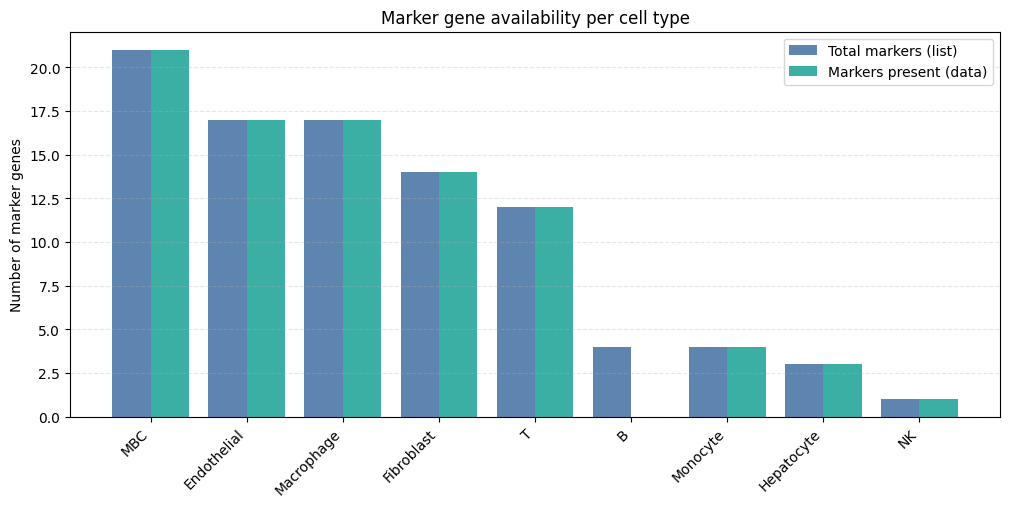

In [5]:
mk = mk_raw.copy()

# strip whitespace from column names
mk.columns = [c.strip() for c in mk.columns]

celltype_col = "CellType"
gene_col = "Marker"

# clean up values
mk[celltype_col] = mk[celltype_col].astype(str).str.strip()
mk[gene_col] = mk[gene_col].astype(str).str.strip()

# which genes are in our dataset
genes_in_data = set(expr.columns)

# how many markers per cell type are in the list
total_per_ct = mk.groupby(celltype_col)[gene_col].nunique()

# how many of those markers actually appear in our data
present_per_ct = (
    mk[mk[gene_col].isin(genes_in_data)]
    .groupby(celltype_col)[gene_col]
    .nunique()
)

# combine into summary table
marker_df = pd.DataFrame({
    "total_markers_in_list": total_per_ct,
    "markers_present_in_data": present_per_ct
}).fillna(0).astype(int)

marker_df = marker_df.sort_values(["total_markers_in_list"], ascending=[False])
display(marker_df)

# bar plot: list markers vs present markers per cell type
fig, ax = plt.subplots(figsize=(12, 5))

x = np.arange(len(marker_df.index))
w = 0.4

ax.bar(x - w/2, marker_df["total_markers_in_list"], width=w, alpha=0.9,
       label="Total markers (list)", color="#4C78A8")
ax.bar(x + w/2, marker_df["markers_present_in_data"], width=w, alpha=0.9,
       label="Markers present (data)", color="#26A69A")

ax.set_xticks(x)
ax.set_xticklabels(marker_df.index, rotation=45, ha="right")
ax.set_ylabel("Number of marker genes")
ax.set_title("Marker gene availability per cell type")
ax.grid(True, axis="y", linestyle="--", alpha=0.3)
ax.legend()


STEP 3: Rebuild AnnData from aligned tables + QC metrics + Seurat-like QC plots

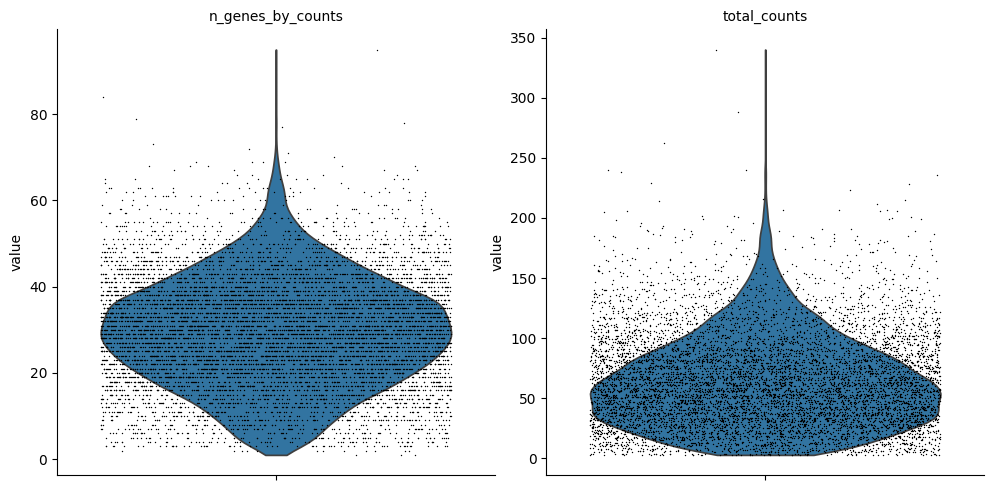

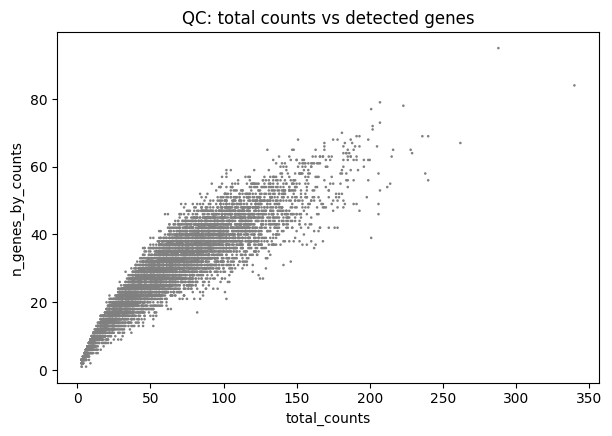

QC medians: total_counts = 59.0 | n_genes_by_counts = 29.0


In [6]:
import scipy.sparse as sp

# build AnnData object from the aligned counts matrix
adata = sc.AnnData(expr.values)
adata.obs_names = expr.index
adata.var_names = expr.columns

# attach spatial coordinates
adata.obsm["spatial"] = loc[[xcol, ycol]].values

# make sure all values are valid floats
X = np.asarray(adata.X, dtype=np.float32)
X[~np.isfinite(X)] = 0.0
X[X < 0] = 0.0
adata.X = X

# save a copy of raw counts so we can always go back to them
adata.layers["counts"] = adata.X.copy()

# flag mitochondrial genes (MT- for human, mt- for mouse)
adata.var["mt"] = adata.var_names.str.upper().str.startswith("MT-") | adata.var_names.str.startswith("mt-")

if "log1p" in adata.uns:
    del adata.uns["log1p"]

# compute QC metrics per cell (library size, genes detected, % mito)
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt"],
    inplace=True,
    percent_top=None,
    layer="counts"
)

# violin plots of QC metrics
qc_keys = ["n_genes_by_counts", "total_counts"]
if "pct_counts_mt" in adata.obs.columns and adata.var["mt"].sum() > 0:
    qc_keys.append("pct_counts_mt")

sc.pl.violin(adata, keys=qc_keys, jitter=0.4, multi_panel=True)

# scatter plots to see relationships between metrics
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", title="QC: total counts vs detected genes")
if "pct_counts_mt" in adata.obs.columns and adata.var["mt"].sum() > 0:
    sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", title="QC: total counts vs percent mitochondrial")
    sc.pl.scatter(adata, x="n_genes_by_counts", y="pct_counts_mt", title="QC: detected genes vs percent mitochondrial")

# print median values
print("QC medians:",
      "total_counts =", float(np.median(adata.obs["total_counts"])),
      "| n_genes_by_counts =", float(np.median(adata.obs["n_genes_by_counts"])))
if "pct_counts_mt" in adata.obs.columns and adata.var["mt"].sum() > 0:
    print("Median pct_counts_mt =", float(np.median(adata.obs["pct_counts_mt"])))


STEP 4: Minimal filtering + normalization + scaling + PCA (Elbow)


After minimal filtering: 8627 cells | 291 genes


/var/folders/_g/3z75f6712896hmqgg1jt1t9h0000gn/T/ipykernel_6300/1046716549.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


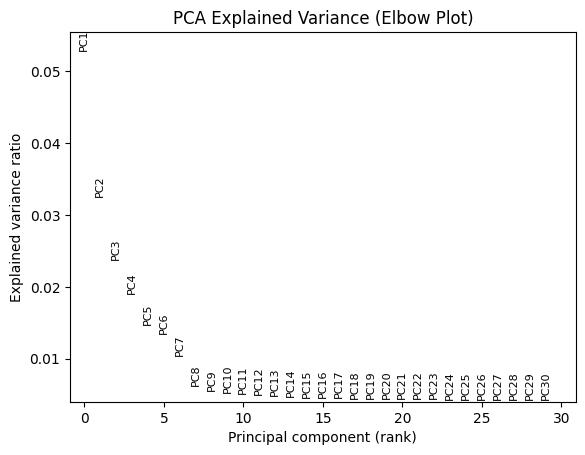

First 20 PCA variance ratios: [0.05282592 0.03258426 0.02374714 0.01908483 0.01476276 0.01347748
 0.01046984 0.00626114 0.00549652 0.00520186 0.00505654 0.0049438
 0.0047983  0.00467438 0.00460721 0.00454262 0.004493   0.00447776
 0.00445055 0.00443458]


In [ ]:
# start from the saved raw counts
if "counts" not in adata.layers:
    raise ValueError('Raw counts layer not found. Run Step 3 first.')

adata.X = adata.layers["counts"].copy()

if sp.issparse(adata.X):
    X = adata.X.toarray().astype(np.float32)
else:
    X = np.asarray(adata.X, dtype=np.float32)

X[~np.isfinite(X)] = 0.0
X[X < 0] = 0.0
adata.X = X

if "log1p" in adata.uns:
    del adata.uns["log1p"]

# remove empty cells and genes
sc.pp.filter_cells(adata, min_counts=1)
sc.pp.filter_cells(adata, min_genes=1)
sc.pp.filter_genes(adata, min_cells=1)

print("After minimal filtering:", adata.n_obs, "cells |", adata.n_vars, "genes")

# normalize each cell to the same total count, then log-transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# save log-normalized data for plotting later
adata.raw = adata

# drop genes with zero variance (would cause NaNs during scaling)
gene_var = np.var(np.asarray(adata.X), axis=0)
keep_genes = gene_var > 0
n_drop = int((~keep_genes).sum())
if n_drop > 0:
    print(f"Removing {n_drop} genes with zero variance before scaling.")
    adata = adata[:, keep_genes].copy()

# scale genes to comparable ranges
sc.pp.scale(adata, max_value=10)

X = np.asarray(adata.X, dtype=np.float32)
X[~np.isfinite(X)] = 0.0
adata.X = X

# run PCA and plot elbow to choose number of components
n_pcs_to_compute = min(30, adata.n_vars - 1, adata.n_obs - 1)
if n_pcs_to_compute < 2:
    raise ValueError(f"Not enough features/cells for PCA (n_vars={adata.n_vars}, n_obs={adata.n_obs}).")

sc.tl.pca(adata, svd_solver="arpack", n_comps=n_pcs_to_compute)

ax = sc.pl.pca_variance_ratio(adata, n_pcs=n_pcs_to_compute, show=False)

if ax is None:
    ax = plt.gca()

ax.set_title("PCA Explained Variance (Elbow Plot)")
ax.set_xlabel("Principal component (rank)")
ax.set_ylabel("Explained variance ratio")

plt.tight_layout()
plt.show()

print("First 20 PCA variance ratios:", adata.uns["pca"]["variance_ratio"][:20])

STEP 5: Neighbors graph + Leiden clustering + UMAP + marker-based scoring

/Users/avitalvasiliev/anaconda3/envs/rnaseq/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/_g/3z75f6712896hmqgg1jt1t9h0000gn/T/ipykernel_6300/3134334901.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1.2, flavor="leidenalg")  # warning about igraph is informational


Number of Leiden clusters: 14
Example marker availability (present markers per cell type):
MBC            21
Endothelial    17
Macrophage     17
Fibroblast     14
T              12
Monocyte        4
Hepatocyte      3
NK              1
B               0
dtype: int64
Scored cell types: ['Endothelial', 'Fibroblast', 'Hepatocyte', 'MBC', 'Macrophage', 'Monocyte', 'T']
Top assigned cell types:
cell_type
MBC            2752
Macrophage     1564
Fibroblast     1181
Endothelial     990
T               819
Hepatocyte      661
Monocyte        660
Name: count, dtype: int64


/var/folders/_g/3z75f6712896hmqgg1jt1t9h0000gn/T/ipykernel_6300/3134334901.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby("leiden")["cell_type"]


,leiden_cluster,major_cell_type,n_cells
0,0,Macrophage,1277
1,1,MBC,962
2,2,MBC,934
3,3,Macrophage,862
4,4,MBC,799
5,5,MBC,675
6,6,Fibroblast,558
7,7,Endothelial,554
8,8,Macrophage,531
9,9,Monocyte,470


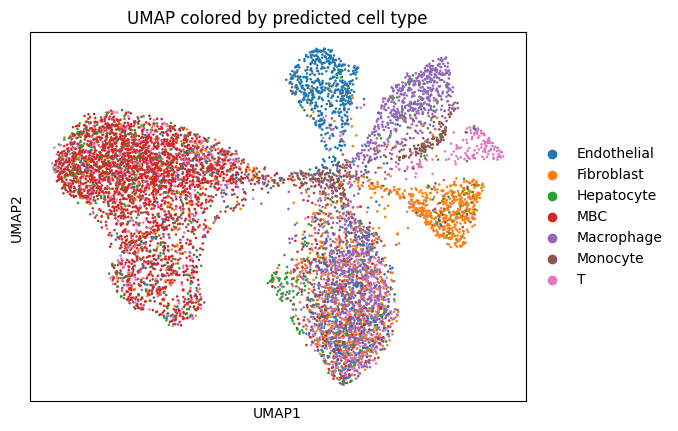

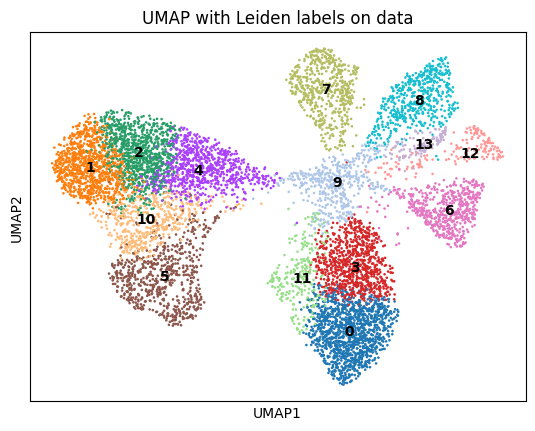

In [ ]:
n_pcs_chosen = 15  # chosen based on the elbow / variance_ratio plateau

sc.pp.neighbors(adata, n_neighbors=12, n_pcs=n_pcs_chosen)
sc.tl.leiden(adata, resolution=1.2, flavor="leidenalg")  # warning about igraph is informational
sc.tl.umap(adata)

print("Number of Leiden clusters:", adata.obs["leiden"].nunique())

if adata.raw is None:
    raise ValueError("adata.raw is missing. Please run STEP 4 (normalization + log1p) before STEP 5.")

celltype_col = "CellType"
gene_col = "Marker"

# Clean marker table
mk = mk_raw.copy()
mk.columns = [c.strip() for c in mk.columns]
mk[celltype_col] = mk[celltype_col].astype(str).str.strip()
mk[gene_col] = mk[gene_col].astype(str).str.strip()

# Build marker dictionary
marker_dict = (
    mk.groupby(celltype_col)[gene_col]
      .apply(lambda s: sorted(set(s)))
      .to_dict()
)

# Gene panel available for scoring
raw_genes = pd.Index(adata.raw.var_names.astype(str))
raw_gene_set = set(raw_genes)

marker_availability = {ct: sum((g in raw_gene_set) for g in genes) for ct, genes in marker_dict.items()}
print("Example marker availability (present markers per cell type):")
print(pd.Series(marker_availability).sort_values(ascending=False).head(10))

score_cols = []
for ct, genes in marker_dict.items():
    genes_in_raw = [g for g in genes if g in raw_gene_set]
    if len(genes_in_raw) < 2:
        continue  # skip tiny sets (unstable score)

    col = f"score_{ct}"

    # Extract expression of marker genes from adata.raw (log-normalized values)
    Xg = adata.raw[:, genes_in_raw].X
    if sp.issparse(Xg):
        adata.obs[col] = np.asarray(Xg.mean(axis=1)).ravel()
    else:
        adata.obs[col] = np.mean(Xg, axis=1)

    score_cols.append(col)

print("Scored cell types:", [c.replace("score_", "") for c in score_cols])

# Assign each cell to the best-scoring cell type
if len(score_cols) == 0:
    adata.obs["cell_type"] = "Unknown"
    adata.obs["cell_type_score"] = 0.0
    print("No cell types could be scored because marker genes did not match the dataset gene panel.")
else:
    scores = adata.obs[score_cols].copy()
    adata.obs["cell_type"] = scores.idxmax(axis=1).str.replace("score_", "", regex=False)
    adata.obs["cell_type_score"] = scores.max(axis=1)

    print("Top assigned cell types:")
    print(adata.obs["cell_type"].value_counts().head(10))

    # For each Leiden cluster, take the most common predicted cell_type
    cluster_to_type = (
        adata.obs.groupby("leiden")["cell_type"]
        .agg(lambda s: s.value_counts().index[0])
        .sort_index()
    )

    cluster_counts = adata.obs["leiden"].value_counts().sort_index()

    legend_df = pd.DataFrame({
        "leiden_cluster": cluster_to_type.index.astype(str),
        "major_cell_type": cluster_to_type.values,
        "n_cells": cluster_counts.values
    })

    display(legend_df)
    sc.pl.umap(adata, color=["cell_type"], title="UMAP colored by predicted cell type")

sc.pl.umap(adata, color=["leiden"], legend_loc="on data", title="UMAP with Leiden labels on data")


STEP 6: High-resolution Leiden clustering

Clusters (original leiden): 14
Clusters (high-res): 7


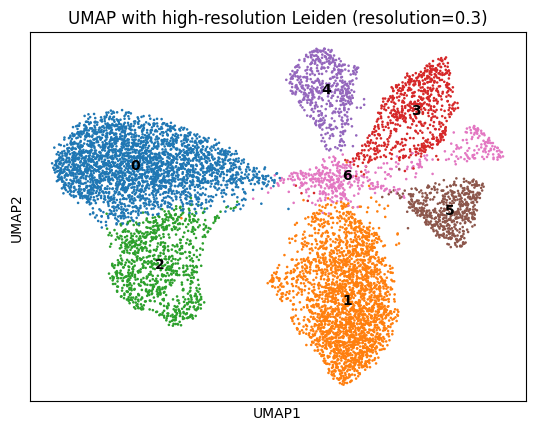

In [12]:
n_pcs_chosen = 15

# rerun neighbors with slightly more neighbors, then cluster at higher resolution
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=n_pcs_chosen)
high_res = 0.3
sc.tl.leiden(adata, resolution=high_res, flavor="leidenalg", key_added="leiden_highres")

print("Clusters (original leiden):", adata.obs["leiden"].nunique())
print("Clusters (high-res):", adata.obs["leiden_highres"].nunique())

sc.pl.umap(
    adata,
    color=["leiden_highres"],
    legend_loc="on data",
    title=f"UMAP with high-resolution Leiden (resolution={high_res})"
)

STEP 7: Mapping (Step 5 -> Step 6) + final clustering plot

/var/folders/_g/3z75f6712896hmqgg1jt1t9h0000gn/T/ipykernel_6300/1484914056.py:118: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby(new_key)[label_key]


,old_cluster_step5,new_cluster_step6,new_cluster_name,old_cluster_n_cells,cells_in_best_new_cluster,purity_fraction,purity_%
0,0,1,Macrophage,1277,1277,1.000000,100.0
1,1,0,MBC,962,962,1.000000,100.0
2,2,0,MBC,934,932,0.997859,99.8
3,3,1,Macrophage,862,862,1.000000,100.0
4,4,0,MBC,799,791,0.989987,99.0
5,5,2,MBC,675,667,0.988148,98.8
6,6,5,Fibroblast,558,531,0.951613,95.2
7,7,4,Endothelial,554,554,1.000000,100.0
8,8,3,Macrophage,531,531,1.000000,100.0
9,9,6,T,470,327,0.695745,69.6



Old clusters (Step 5) -> New clusters (Step 6) mapping:
old | new | new_name       | n_old | n_in_new | purity
-----------------------------------------------------------------
  0 |   1 | Macrophage     |  1277 |    1277 | 1.00
  1 |   0 | MBC            |   962 |     962 | 1.00
  2 |   0 | MBC            |   934 |     932 | 1.00
  3 |   1 | Macrophage     |   862 |     862 | 1.00
  4 |   0 | MBC            |   799 |     791 | 0.99
  5 |   2 | MBC            |   675 |     667 | 0.99
  6 |   5 | Fibroblast     |   558 |     531 | 0.95
  7 |   4 | Endothelial    |   554 |     554 | 1.00
  8 |   3 | Macrophage     |   531 |     531 | 1.00
  9 |   6 | T              |   470 |     327 | 0.70
 10 |   2 | MBC            |   466 |     258 | 0.55
 11 |   1 | Macrophage     |   257 |     256 | 1.00
 12 |   6 | T              |   166 |     164 | 0.99
 13 |   3 | Macrophage     |   116 |     116 | 1.00
-----------------------------------------------------------------


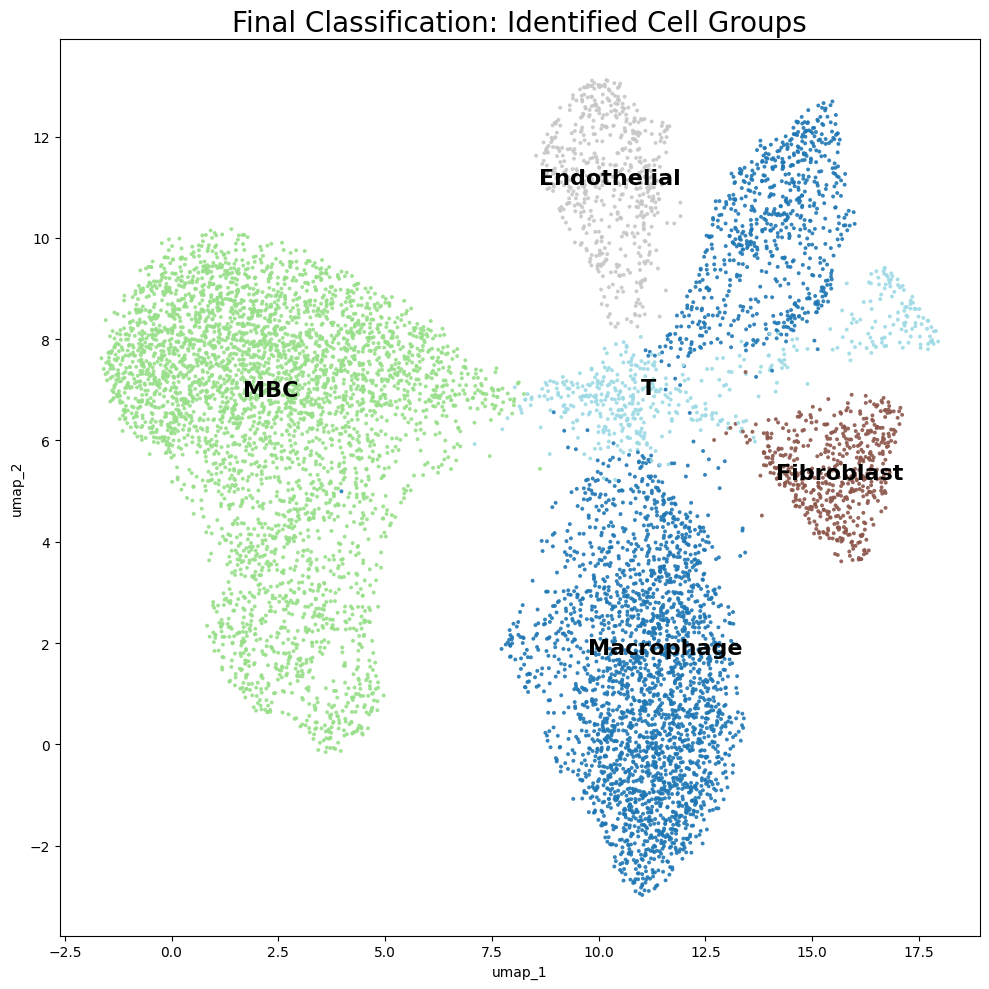

In [13]:
# Keys used in adata.obs
old_key   = "leiden"            # Step 5 clusters (original)
new_key   = "leiden_highres"    # Step 6 clusters (high-resolution)
label_key = "final_cell_group"  # will be CREATED here

# Marker table columns (mk_raw)
celltype_col = "CellType"
gene_col     = "Marker"


# Validate required inputs exist
for k in [old_key, new_key]:
    if k not in adata.obs.columns:
        raise ValueError(f"Missing adata.obs['{k}']. Make sure STEP 5 and STEP 6 ran successfully.")

if adata.raw is None:
    raise ValueError("adata.raw is missing. After normalization/log1p do: adata.raw = adata.copy()")

if "X_umap" not in adata.obsm:
    raise ValueError("UMAP not found in adata.obsm['X_umap']. Run sc.tl.umap(adata) before plotting.")

if "mk_raw" not in globals():
    raise ValueError("mk_raw is not defined. Load the marker table into mk_raw first.")

if celltype_col not in mk_raw.columns or gene_col not in mk_raw.columns:
    raise ValueError(f"mk_raw must contain columns '{celltype_col}' and '{gene_col}'.")


cluster_key = new_key  

# clean marker table
mk = mk_raw.copy()
mk.columns = [c.strip() for c in mk.columns]
mk[celltype_col] = mk[celltype_col].astype(str).str.strip()
mk[gene_col]     = mk[gene_col].astype(str).str.strip()

# build marker dictionary: cell type -> unique marker list
marker_dict = (
    mk.groupby(celltype_col)[gene_col]
      .apply(lambda s: sorted(set(s.dropna().astype(str))))
      .to_dict()
)

raw_genes = pd.Index(adata.raw.var_names.astype(str))
raw_gene_set = set(raw_genes)

# keep only markers that exist in our dataset
marker_dict_in_data = {
    ct: [g for g in genes if g in raw_gene_set]
    for ct, genes in marker_dict.items()
}

def marker_score_per_cluster(adata, genes, cluster_key):
    """Per-cluster mean expression score for a gene set (using adata.raw)."""
    Xg = adata.raw[:, genes].X
    if sp.issparse(Xg):
        per_cell = np.asarray(Xg.mean(axis=1)).ravel()
    else:
        per_cell = np.mean(Xg, axis=1)
    return pd.Series(per_cell, index=adata.obs_names).groupby(adata.obs[cluster_key].astype(str)).mean()

# score each cluster against each cell type
clusters6 = adata.obs[cluster_key].astype(str)
cluster_ids = sorted(clusters6.unique(), key=lambda x: int(x) if str(x).isdigit() else str(x))

score_table = pd.DataFrame(index=cluster_ids)

for ct, genes in marker_dict_in_data.items():
    if len(genes) < 2:      # skip tiny gene sets
        continue
    score_table[ct] = marker_score_per_cluster(adata, genes, cluster_key).reindex(cluster_ids)

if score_table.shape[1] == 0:
    raise ValueError("No usable marker gene sets after filtering. Check gene symbols in mk_raw vs adata.raw.var_names.")

best_ct = score_table.idxmax(axis=1)
best_score = score_table.max(axis=1)

second_best = score_table.apply(
    lambda r: r.nlargest(2).iloc[-1] if r.notna().sum() >= 2 else np.nan,
    axis=1
)
confidence = (best_score - second_best).fillna(0.0)

cluster_diagnosis = pd.DataFrame({
    "cluster_step6_id": score_table.index.astype(str),
    "identified_as": best_ct.values.astype(str),
    "confidence_score": confidence.values.astype(float)
})

# assign label to each cell
cluster_to_label = dict(zip(cluster_diagnosis["cluster_step6_id"], cluster_diagnosis["identified_as"]))
adata.obs[label_key] = clusters6.map(cluster_to_label).astype("category")

# mapping Step 5 -> Step 6 
old = adata.obs[old_key].astype(str)
new = adata.obs[new_key].astype(str)
lab = adata.obs[label_key].astype(str)

overlap = pd.crosstab(old, new)

def sort_cluster_ids(index_like):
    """Sort cluster IDs numerically when possible (e.g., '0','1','10'), otherwise lexicographically."""
    vals = list(index_like)
    def key_fn(x):
        return (0, int(x)) if str(x).isdigit() else (1, str(x))
    return sorted(vals, key=key_fn)

overlap = overlap.loc[sort_cluster_ids(overlap.index), sort_cluster_ids(overlap.columns)]

best_new_for_old = overlap.idxmax(axis=1)
old_size         = overlap.sum(axis=1)
max_overlap      = overlap.max(axis=1)
purity           = (max_overlap / old_size).fillna(0.0)

# name each new cluster by its dominant cell type
new_cluster_name = (
    adata.obs.groupby(new_key)[label_key]
    .agg(lambda s: s.value_counts().index[0] if len(s) else "Unknown")
    .astype(str)
    .to_dict()
)

mapping_df = pd.DataFrame({
    "old_cluster_step5": overlap.index.astype(str),
    "new_cluster_step6": best_new_for_old.values.astype(str),
    "new_cluster_name":  [new_cluster_name.get(cid, "Unknown") for cid in best_new_for_old.values.astype(str)],
    "old_cluster_n_cells": old_size.values.astype(int),
    "cells_in_best_new_cluster": max_overlap.values.astype(int),
    "purity_fraction": purity.values
}).reset_index(drop=True)

mapping_df["purity_%"] = (mapping_df["purity_fraction"] * 100).round(1)

mapping_df = mapping_df.sort_values(
    "old_cluster_step5",
    key=lambda s: s.map(lambda x: int(x) if str(x).isdigit() else 10**9)
).reset_index(drop=True)

display(mapping_df)

print("\nOld clusters (Step 5) -> New clusters (Step 6) mapping:")
print(f"{'old':>3} | {'new':>3} | {'new_name':<14} | {'n_old':>5} | {'n_in_new':>7} | {'purity':>6}")
print("-" * 65)
for _, r in mapping_df.iterrows():
    print(f"{r['old_cluster_step5']:>3} | {r['new_cluster_step6']:>3} | {r['new_cluster_name']:<14} | "
          f"{r['old_cluster_n_cells']:>5} | {r['cells_in_best_new_cluster']:>7} | {float(r['purity_fraction']):.2f}")
print("-" * 65)

# final UMAP plot colored by cell type
umap = adata.obsm["X_umap"]

codes, _ = pd.factorize(lab)

plt.figure(figsize=(10, 10))
plt.scatter(umap[:, 0], umap[:, 1], c=codes, s=8, cmap="tab20", linewidths=0, alpha=0.9)
plt.title("Final Classification: Identified Cell Groups", fontsize=20)
plt.xlabel("umap_1")
plt.ylabel("umap_2")

for g in pd.unique(lab):
    mask = (lab == g).values
    if mask.sum() < 30:
        continue
    x_med = np.median(umap[mask, 0])
    y_med = np.median(umap[mask, 1])
    plt.text(x_med, y_med, g, fontsize=16, weight="bold",
             ha="center", va="center", color="black")

plt.tight_layout()
plt.show()


STEP 8: Clinical Cell Type Distribution

,percentage,n_cells
cell_type_clinical,,
MBC,36.872609,3181
Macrophage,21.676133,1870
Fibroblast,15.393532,1328
T,13.492523,1164
Endothelial,12.565202,1084


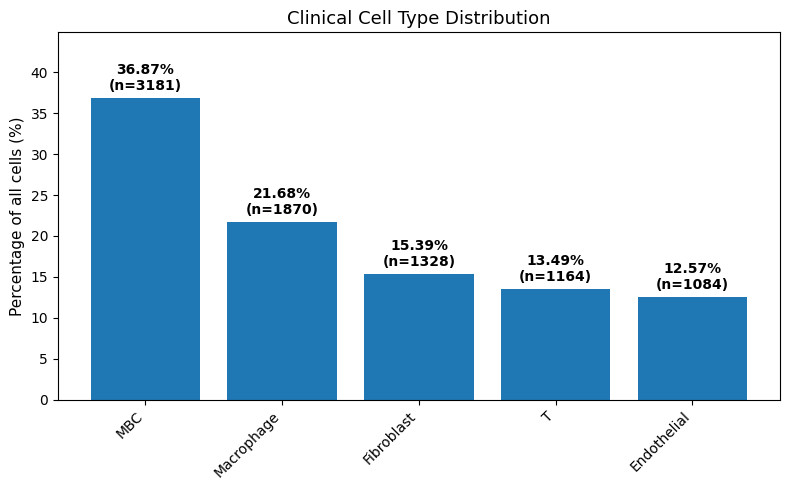

Total cells analyzed: 8627
Total sum of graph bars: 100.0%
Immune Percentage (T+B+Macrophage): 35.17%
Meets 10% threshold for Q1: True


In [29]:
target_groups = ["MBC", "Macrophage", "Fibroblast", "Endothelial", "T"]
score_cols = [f"score_{ct}" for ct in target_groups if f"score_{ct}" in adata.obs.columns]

# Safety check: ensure scoring columns exist 
if len(score_cols) == 0:
    raise ValueError(
        "No score_* columns found for the target groups. "
        "Run the marker scoring step first (creates score_<CellType> in adata.obs)." )


# For each cell, pick the clinical group with the highest marker score among the 5 groups.
focused_scores = adata.obs[score_cols]
adata.obs["cell_type_clinical"] = (
    focused_scores.idxmax(axis=1).str.replace("score_", "", regex=False)
)

# summarize distribution (counts + percentages)
clinical_counts = adata.obs["cell_type_clinical"].value_counts()
clinical_pct = (clinical_counts / clinical_counts.sum()) * 100

dist_df = pd.DataFrame({
    "percentage": clinical_pct,
    "n_cells": clinical_counts
}).sort_values(by="percentage", ascending=False)

display(dist_df)


plt.figure(figsize=(8, 5))
bars = plt.bar(dist_df.index, dist_df["percentage"]) 

plt.title("Clinical Cell Type Distribution", fontsize=13)
plt.ylabel("Percentage of all cells (%)", fontsize=11)
plt.xlabel("")
plt.xticks(rotation=45, ha="right")

# add labels on top of each bar (percentage + n cells)
for bar, (pct, n) in zip(bars, zip(dist_df["percentage"].values, dist_df["n_cells"].values)):
    plt.text(bar.get_x() + bar.get_width() / 2,
        pct + 0.6,
        f"{pct:.2f}%\n(n={int(n)})",
        ha="center",
        va="bottom",
        fontweight="bold")

plt.ylim(0, float(dist_df["percentage"].max()) + 8)
plt.tight_layout()
plt.show()


# Q1 preparation: immune-cell percentage (clinical labels)

immune_types = ["T", "B", "Macrophage"]
immune_pct = adata.obs["cell_type_clinical"].isin(immune_types).mean() * 100
q1_yes = immune_pct >= 10

print(f"Total cells analyzed: {adata.n_obs}")
print(f"Total sum of graph bars: {dist_df['percentage'].sum():.1f}%")
print(f"Immune Percentage (T+B+Macrophage): {immune_pct:.2f}%")
print(f"Meets 10% threshold for Q1: {q1_yes}")
# =========================================================

STEP 9: Spatial mapping + computations needed for Q2/Q3

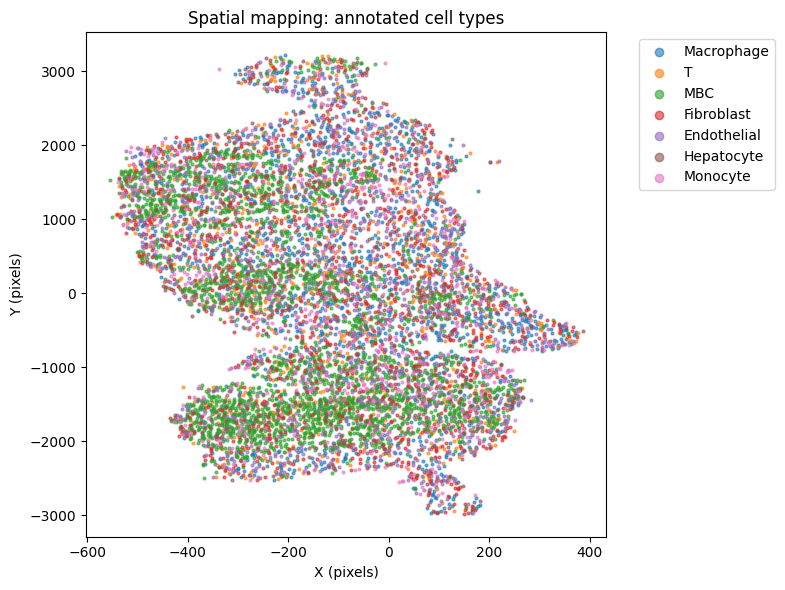

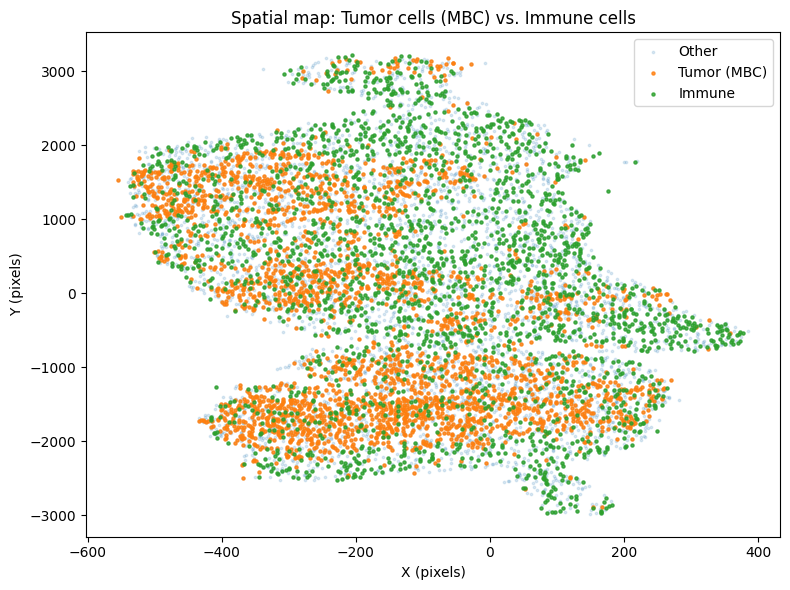

In [21]:
coords = adata.obsm["spatial"]

tumor_label  = "MBC"
immune_types = ["T", "B", "Macrophage"]

immune_mask = adata.obs["cell_type"].isin(immune_types).values
tumor_mask  = (adata.obs["cell_type"] == tumor_label).values

# spatial map of all cell types
plt.figure(figsize=(8, 6))
for ct in adata.obs["cell_type"].unique():
    m = (adata.obs["cell_type"] == ct).values
    plt.scatter(coords[m, 0], coords[m, 1], s=4, alpha=0.6, label=ct)

plt.title("Spatial mapping: annotated cell types")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.legend(markerscale=3, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# tumor vs immune spatial map — used to assess Q2 (mixing)
plt.figure(figsize=(8, 6))
plt.scatter(coords[:, 0], coords[:, 1], s=3, alpha=0.15, label="Other")
plt.scatter(coords[tumor_mask, 0], coords[tumor_mask, 1], s=5, alpha=0.8, label=f"Tumor ({tumor_label})")
plt.scatter(coords[immune_mask, 0], coords[immune_mask, 1], s=5, alpha=0.8, label="Immune")

plt.title("Spatial map: Tumor cells (MBC) vs. Immune cells")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.legend()
plt.tight_layout()
plt.show()

# q2_yes will be set manually after looking at the plot above
q2_yes = None

# compute PD-L1 positivity from raw counts (CD274 >= 1 = positive)
pdl1_gene = "CD274"

if adata.raw is None:
    raise ValueError("adata.raw is missing. Store raw counts before normalization.")

rawX    = adata.raw.X
raw_mat = rawX.toarray() if sp.issparse(rawX) else np.array(rawX)

raw_genes = list(adata.raw.var_names)
if pdl1_gene not in raw_genes:
    raise ValueError(f"{pdl1_gene} not found in adata.raw.var_names.")

pdl1_idx    = raw_genes.index(pdl1_gene)
pdl1_counts = raw_mat[:, pdl1_idx]

pdl1_positive = (pdl1_counts >= 1)
pdl1_pct      = pdl1_positive.mean() * 100
q3_yes        = pdl1_pct >= 10


PD-L1 (CD274) — Spatial map (minimal/original) + Q3 percent

Q3 | % cells with CD274 raw>=1: 0.66%  ->  NO


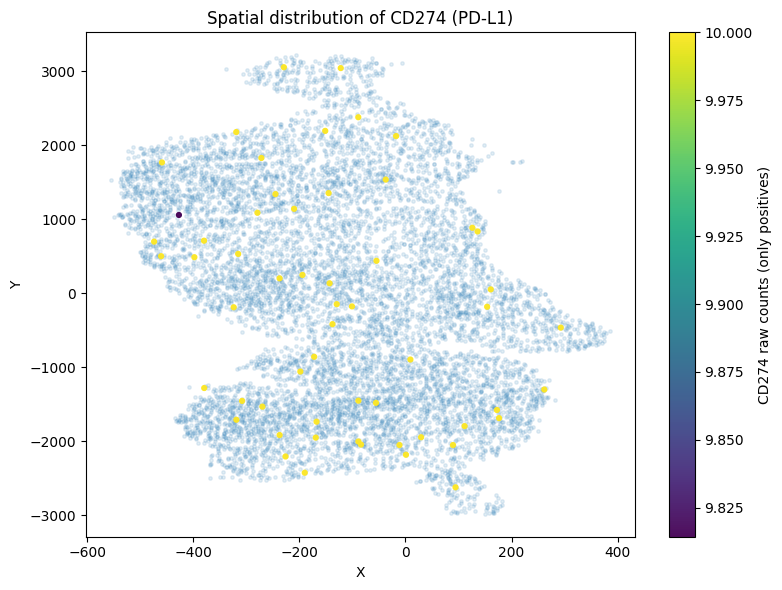

In [28]:
pdl1_gene = "CD274"  # PD-L1 gene symbol

# Checks
if "spatial" not in adata.obsm:
    raise ValueError('Missing adata.obsm["spatial"]. Make sure you saved spatial coordinates earlier.')
if adata.raw is None:
    raise ValueError("adata.raw is missing. Save raw counts earlier with: adata.raw = adata.copy() (before normalize/log).")

coords = adata.obsm["spatial"]

# Raw counts for CD274
rawX = adata.raw.X
raw_genes = list(adata.raw.var_names)
if pdl1_gene not in raw_genes:
    raise ValueError(f"{pdl1_gene} not found in adata.raw.var_names. Check gene naming in your dataset.")

pdl1_idx = raw_genes.index(pdl1_gene)
raw_mat = rawX.toarray() if sp.issparse(rawX) else np.asarray(rawX)
pdl1_counts = raw_mat[:, pdl1_idx].astype(float)

# Q3 threshold: raw>=1
pdl1_pos = (pdl1_counts >= 1)
pdl1_pct = 100.0 * pdl1_pos.mean()
q3_yes = (pdl1_pct >= 10)

print(f"Q3 | % cells with {pdl1_gene} raw>=1: {pdl1_pct:.2f}%  ->  {'YES' if q3_yes else 'NO'}")


plt.figure(figsize=(8, 6))
plt.scatter(coords[:, 0], coords[:, 1], s=6, alpha=0.12)
scat = plt.scatter(
    coords[pdl1_pos, 0], coords[pdl1_pos, 1],
    c=pdl1_counts[pdl1_pos],
    s=12, alpha=0.95
)

plt.title("Spatial distribution of CD274 (PD-L1)")
plt.xlabel("X")
plt.ylabel("Y")

cbar = plt.colorbar(scat)
cbar.set_label(f"{pdl1_gene} raw counts (only positives)")

plt.tight_layout()
plt.show()
